In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import scienceplots
from scipy.interpolate import interp2d, interp1d
from scipy.signal.windows import hann, blackman, hamming
from scipy.signal import savgol_filter
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")

import nanonets_utils
import nanonets

def plot_freq(f1, f2, ax, min_y, max_y):

    ax.vlines(f1, min_y, max_y, colors='#348ABD', linestyles='dashed')
    ax.vlines(f2, min_y, max_y, colors='#348ABD', linestyles='dashed')

    ax.vlines(f2-f1, min_y, max_y, colors='#A60628', linestyles='dotted')
    ax.vlines(f2+f1, min_y, max_y, colors='#A60628', linestyles='dotted')
    ax.vlines(2*f2, min_y, max_y, colors='#A60628', linestyles='dotted')
    ax.vlines(2*f1, min_y, max_y, colors='#A60628', linestyles='dotted')
    ax.vlines(f2+2*f1, min_y, max_y, colors='#A60628', linestyles='dotted')
    ax.vlines(f1+2*f2, min_y, max_y, colors='#A60628', linestyles='dotted')
    ax.vlines(np.abs(f2-2*f1), min_y, max_y, colors='#A60628', linestyles='dotted')
    ax.vlines(np.abs(f1-2*f2), min_y, max_y, colors='#A60628', linestyles='dotted')
    
    return ax

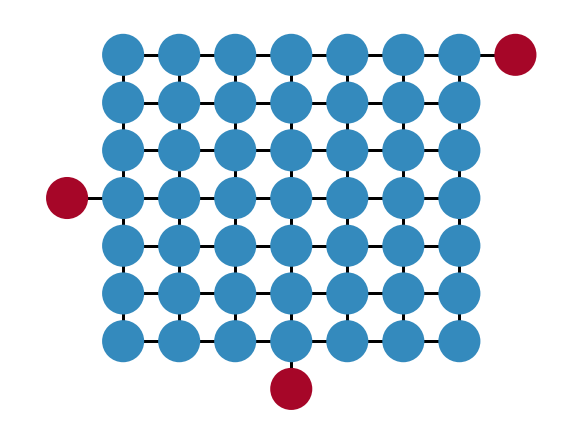

In [2]:
# Network Topology
N   = 7
topology_parameter  = {
    "Nx"    :   N,
    "Ny"    :   N,
    "Nz"    :   1,
    "e_pos" :   [[int((N-1)/2),0,0],[0,int((N-1)/2),0],[N-1,N-1,0]],
}
sim_class   = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)

with plt.style.context(["science","bright", "grid"]):
    fig         = plt.figure(dpi=200)
    ax          = fig.add_subplot()
    fig, ax     = nanonets_utils.display_network(sim_class, node_size=200, fig=fig, ax=ax)
    fig.savefig("plots/network.png")

In [3]:
time_vals   = np.loadtxt("../uniform/time.csv")*1e9
time_vals   = np.delete(time_vals,-1)
dic_freq    = {N : pd.read_csv(f"../uniform/data/Nx={N}_Ny={N}_Nz=1_Ne=3.csv") for N in range(3,12)}

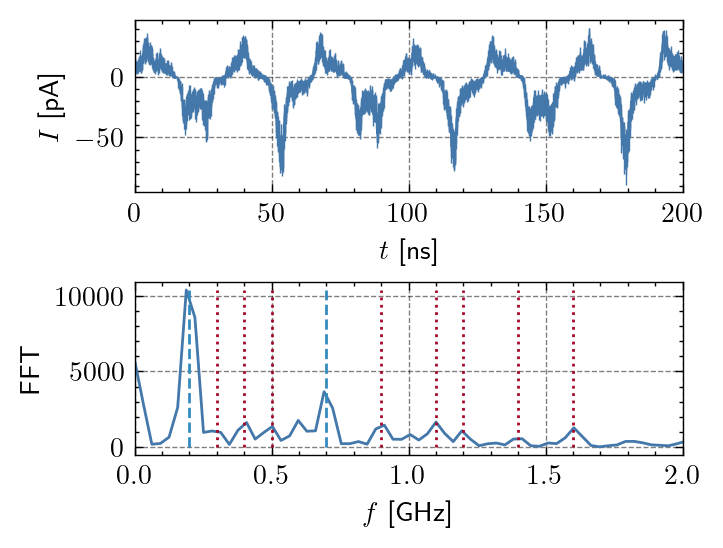

In [4]:
N       = 7
start   = 0
signal  = dic_freq[N]['Current'].values[start:]
error   = dic_freq[N]['Error'].values[start:]
dt      = 1e-10
xf, yf  = nanonets_utils.fft(signal, dt)

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')

    ax  = fig.add_subplot(2,1,1)
    ax.errorbar(time_vals[start:], signal, error, marker='', markevery=2, lw=0.5)
    ax.set_ylabel('$I$ [pA]')
    ax.set_xlabel('$t$ [ns]')
    ax.set_xlim(0,200)

    ax  = fig.add_subplot(2,1,2)
    ax.plot(xf, yf)
    ax.set_xlim(0,2)
    # ax.set_yscale('log')
    ax = plot_freq(0.2, 0.7, ax, np.min(yf), np.max(yf))
    ax.set_xlabel("$f$ [GHz]")
    ax.set_ylabel('FFT')
    fig.savefig(f"plots/I_FFT_{N}.png")

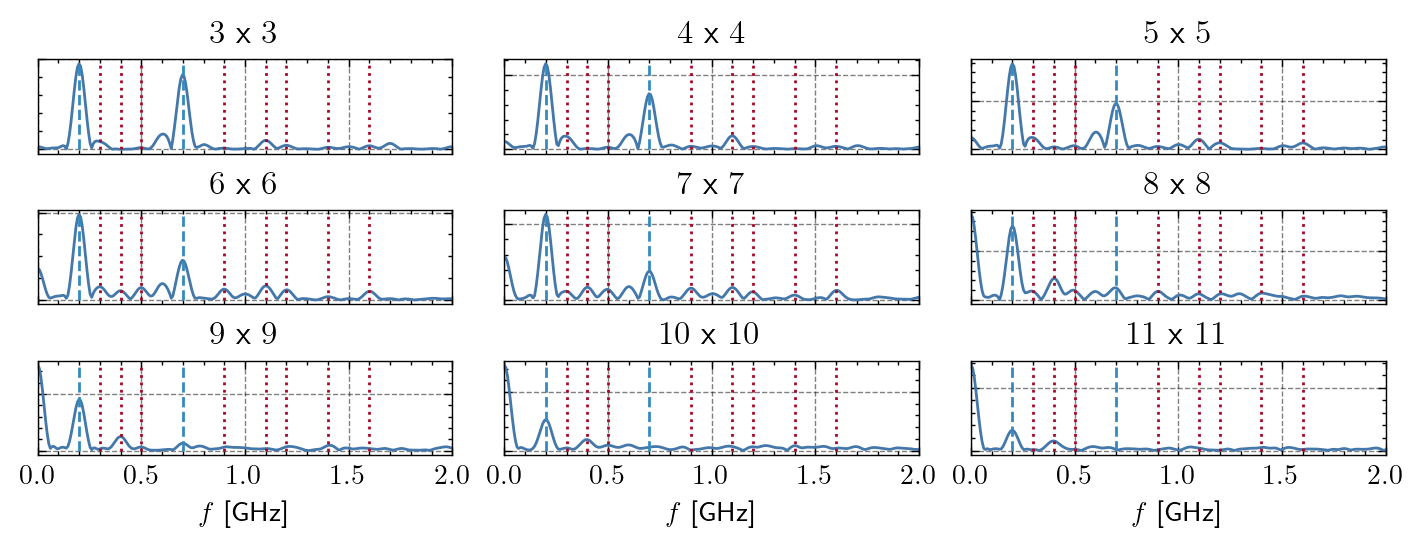

In [17]:
with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    # fig.set_figheight(fig.get_figheight()*2)

    for i,N in enumerate([3,4,5,6,7,8,9,10,11]):

        ax      = fig.add_subplot(3,3,i+1)
        signal  = dic_freq[N]['Current']
        error   = dic_freq[N]['Error']
        dt      = 1e-10
        xf, yf  = nanonets_utils.fft(signal, dt, n_padded=8192)
        ax.plot(xf, yf)
        ax = plot_freq(0.2, 0.7, ax, np.min(yf), np.max(yf))
        ax.set_xlim(0,2)
        ax.set_yticklabels("")
        ax.set_title(f"${N}$ x ${N}$")

        if i >= 6:
            ax.set_xlabel("$f$ [GHz]")
        else:
            ax.set_xticklabels("")
    
    fig.savefig(f"plots/FFT_comparsion.png")

In [45]:
def multiplot_observable_based_on_network(x_vals : pd.DataFrame, y_vals : pd.DataFrame, N : int,
                                          fig_scale=(1.5,1.5), x_lim=None, y_lim=None, y_label='y',
                                          x_label='x', log_x=False, log_y=False, style_context=["science","bright","grid"]):
    
    with plt.style.context(style_context):
        
        fig, axs    = plt.subplots(ncols=N, nrows=N, layout='constrained')
        width       = fig.get_figwidth()
        fig.set_figwidth(width*fig_scale[0])
        fig.set_figheight(width*fig_scale[1])

        if x_lim == None:
            x_lim = [x_vals.min().min(), x_vals.max().max()]

        if y_lim == None:
            y_lim = [y_vals.min().min(), y_vals.max().max()]

        i = 0

        for row in np.arange((N-1),-1,-1):
            for col in range(0,N):

                axs[row,col].plot(x_vals[i], y_vals[i])
                axs[row,col].set_xlim(x_lim[0],x_lim[1])
                axs[row,col].set_ylim(y_lim[0],y_lim[1])

                if i % N != 0:
                    axs[row,col].set_yticklabels("")
                else:    
                    axs[row,col].set_ylabel(y_label)

                if (i > N-1):
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel(x_label)

                if log_x:
                    axs[row,col].set_xscale('log')

                if log_y:
                    axs[row,col].set_yscale('log')

                i += 1

    return fig, axs

In [50]:
dic_states      = {N : pd.read_csv(f"../uniform/data/mean_state_Nx={N}_Ny={N}_Nz=1_Ne=3.csv") for N in range(3,11)}
dic_states_fft  = {}
dt              = 1e-10
n_padded        = 7000

for key, df in dic_states.items():

    x_vals, y_vals = [],[]

    for col in df.columns:
        
        signal      = df[col].values - np.mean(df[col].values)
        xf, yf      = nanonets_utils.fft(signal, dt, n_padded=8192)
        
        x_vals.append(xf)
        y_vals.append(yf)

    dic_states_fft[key] = [pd.DataFrame(x_vals).T, pd.DataFrame(y_vals).T]

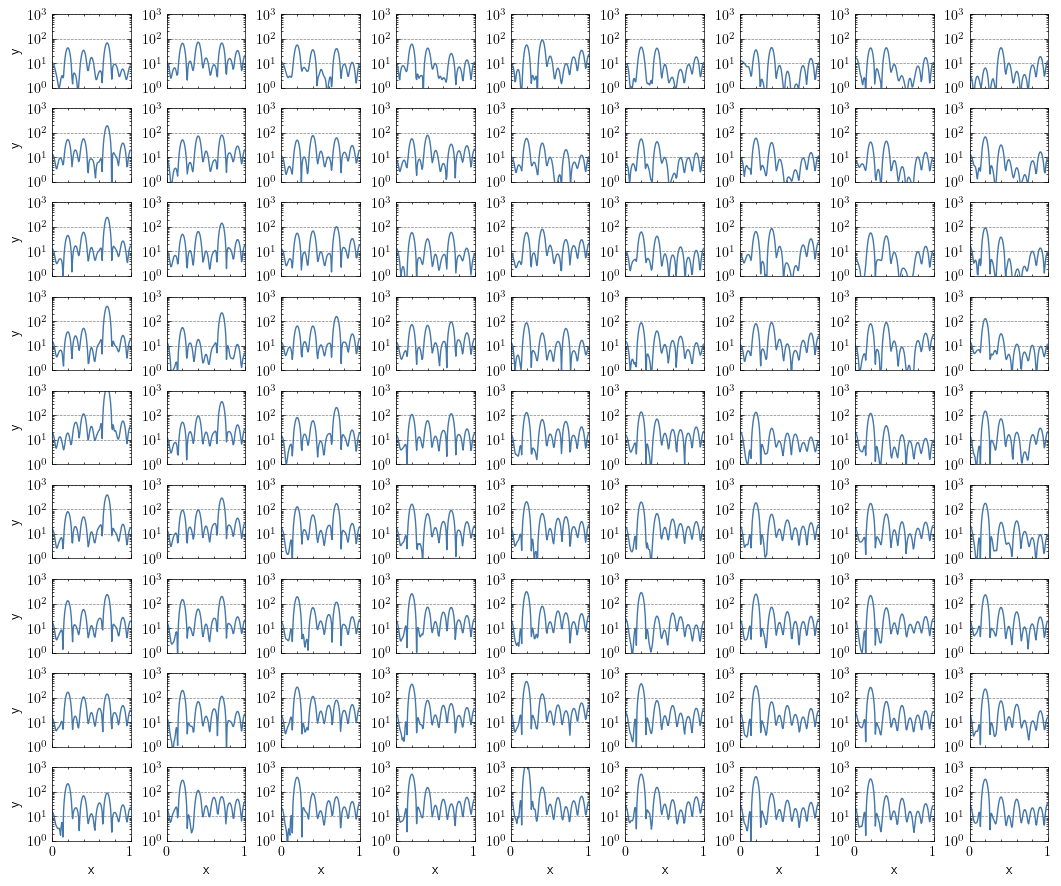

In [51]:
N       = 9
fig, ax = multiplot_observable_based_on_network(dic_states_fft[N][0], dic_states_fft[N][1], N,
                                                x_lim=(0,1), y_lim=(1,1000), log_y=True, fig_scale=(3,2.5))

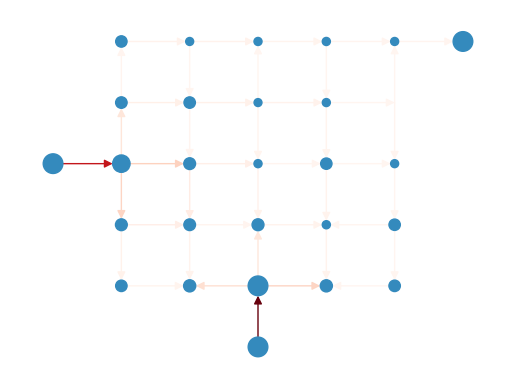

In [64]:
N                   = 5
topology_parameter  = {
    "Nx"    :   N,
    "Ny"    :   N,
    "Nz"    :   1,
    "e_pos" :   [[int((N-1)/2),0,0],[0,int((N-1)/2),0],[N-1,N-1,0]],
}
sim_class   = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)


fig, ax     = nanonets_utils.display_network_currents(f"../uniform/data/net_currents_Nx={N}_Ny={N}_Nz=1_Ne=3.csv",
                                                      row=1, N_electrodes=3, pos=sim_class.pos, node_size=200, arrow_scale=2, charge_landscape=True)

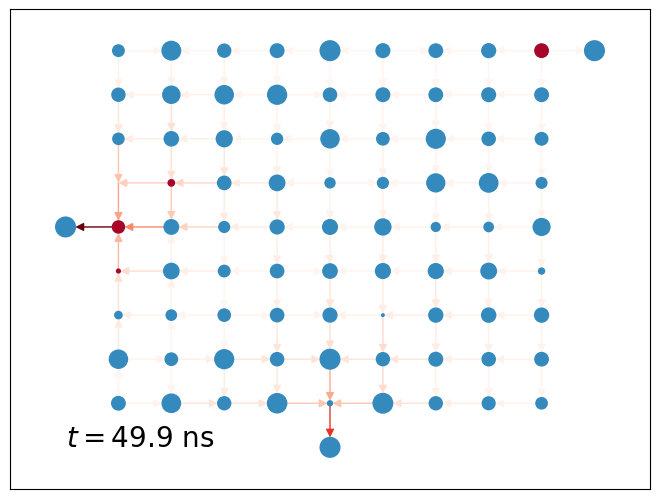

In [88]:
N           = 9
fig         = plt.figure()
ax          = fig.add_subplot()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

frames  = []

for row in range(500):

    ax.clear()
    topology_parameter  = {
        "Nx"    :   N,
        "Ny"    :   N,
        "Nz"    :   1,
        "e_pos" :   [[int((N-1)/2),0,0],[0,int((N-1)/2),0],[N-1,N-1,0]],
    }
    sim_class   = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    fig, ax     = nanonets_utils.display_network_currents(f"../uniform/data/net_currents_Nx={N}_Ny={N}_Nz=1_Ne=3.csv",
                                                          row=row, N_electrodes=3, pos=sim_class.pos, node_size=200, arrow_scale=2,
                                                          charge_landscape=True, fig=fig, ax=ax)

    ax.text(x=-1, y=-1, s=f"$t = {np.round(time_vals[row],2)}$ ns", fontsize=20)
    fig.canvas.draw()

    frame   = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    frame   = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

writer = animation.PillowWriter(fps=10)

# Save the animation as a GIF
with writer.saving(fig, f"plots/animations/uniform_N={N}.gif", dpi=100):
    for frame in frames:
        ax.clear()  # Clear the axis
        ax.imshow(frame)  # Display the frame
        writer.grab_frame()  # Grab the frame

-------------

In [7]:
N       = 9
df_low  = pd.read_csv(f"../uniform/data/Nx={N}_Ny={N}_Nz=1_Ne=3.csv")
df_high = pd.read_csv(f"../uniform_high/data/Nx={N}_Ny={N}_Nz=1_Ne=3.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../uniform_high/data/Nx=9_Ny=9_Nz=1_Ne=3.csv'

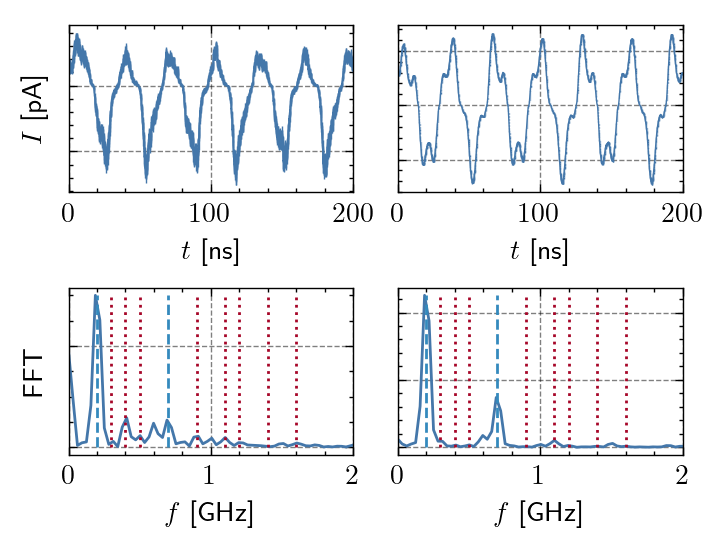

In [26]:
start   = 0
dt      = 1e-10
bm      = hann(len(signal))

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')

    signal  = df_low['Current'].values[start:]
    error   = df_low['Error'].values[start:]
    xf, yf  = nanonets_utils.fft(signal*bm, dt)

    ax  = fig.add_subplot(2,2,1)
    ax.errorbar(time_vals[start:], signal, error, marker='', markevery=2, lw=0.5)
    ax.set_ylabel('$I$ [pA]')
    ax.set_xlabel('$t$ [ns]')
    ax.set_xlim(0,200)
    ax.set_yticklabels("")

    ax  = fig.add_subplot(2,2,3)
    ax.plot(xf, yf)
    ax.set_xlim(0,2)
    # ax.set_yscale('log')
    ax = plot_freq(0.2, 0.7, ax, np.min(yf), np.max(yf))
    ax.set_xlabel("$f$ [GHz]")
    ax.set_ylabel('FFT')
    ax.set_yticklabels("")

    signal  = df_high['Current'].values[start:]
    error   = df_high['Error'].values[start:]
    xf, yf  = nanonets_utils.fft(signal*bm, dt)

    ax  = fig.add_subplot(2,2,2)
    ax.errorbar(time_vals[start:], signal, error, marker='', markevery=2, lw=0.5)
    ax.set_ylabel('')
    ax.set_xlabel('$t$ [ns]')
    ax.set_xlim(0,200)
    ax.set_yticklabels("")

    ax  = fig.add_subplot(2,2,4)
    ax.plot(xf, yf)
    ax.set_xlim(0,2)
    ax.set_yticklabels("")
    # ax.set_yscale('log')
    ax = plot_freq(0.2, 0.7, ax, np.min(yf), np.max(yf))
    ax.set_xlabel("$f$ [GHz]")
    ax.set_ylabel('')


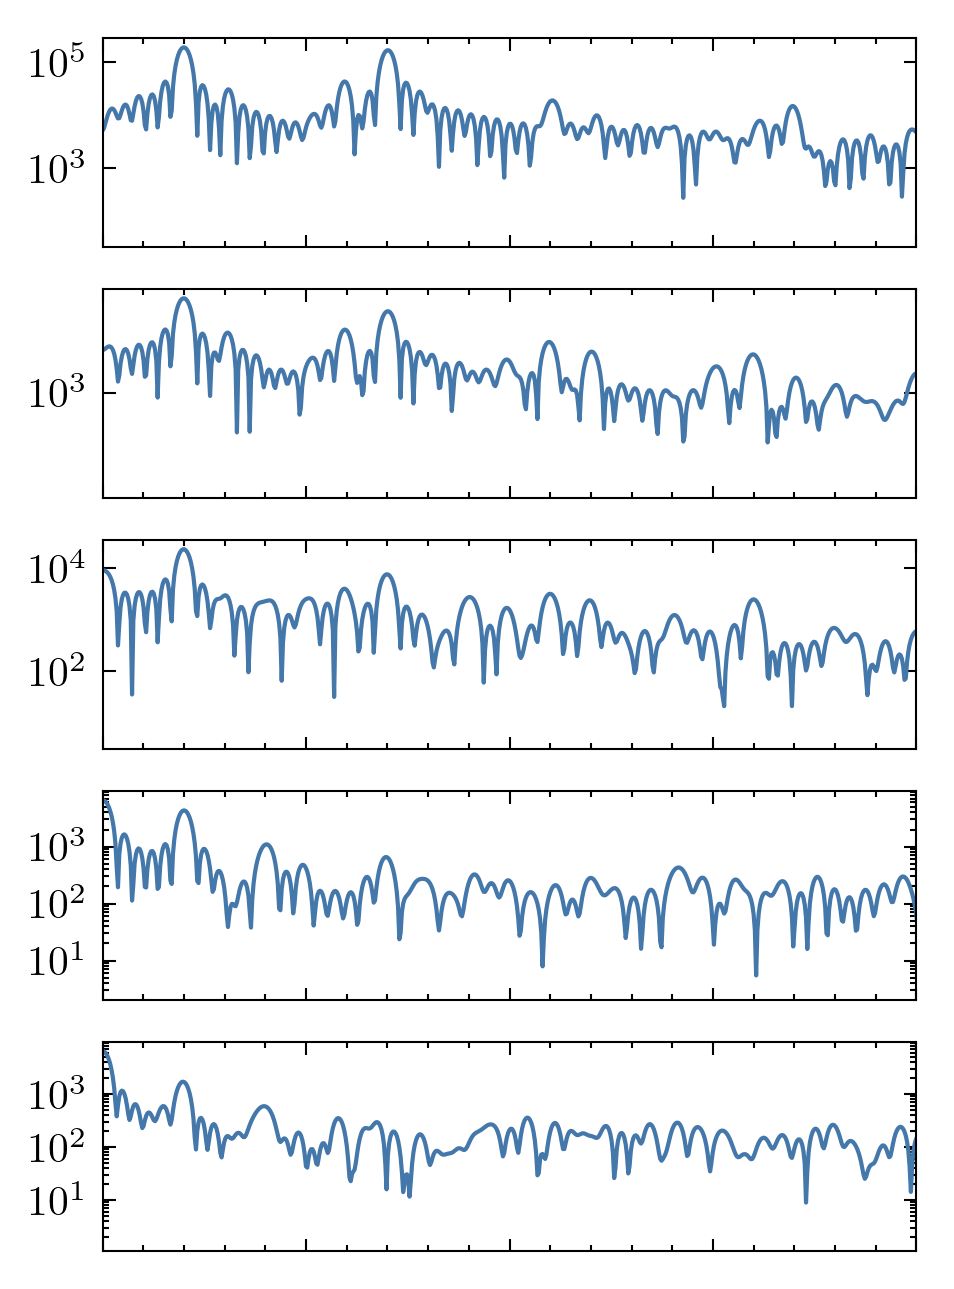

In [79]:
N       = 3
f1      = 20e7/1e9
f2      = 70e7/1e9
signal  = dic_freq[N]['Current']
xf, yf  = fft(signal, 1e-10)

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=300)
    fig.set_figheight(fig.get_figheight()*2)

    for i, N in enumerate([3,5,7,9,11]):

        ax  = fig.add_subplot(5,1,i+1)

        signal  = dic_freq[N]['Current']
        xf, yf  = fft(signal, 1e-10, factor=10)

        ax.plot(xf/1e9, yf)
        # ax  = plot_freq(f1, f2, ax, 0, 1e5)
        ax.set_yscale('log')
        ax.set_xlim(0,2)
        ax.set_xticklabels('')

    # plt.yscale('log')
    # plt.xlim(0,2)

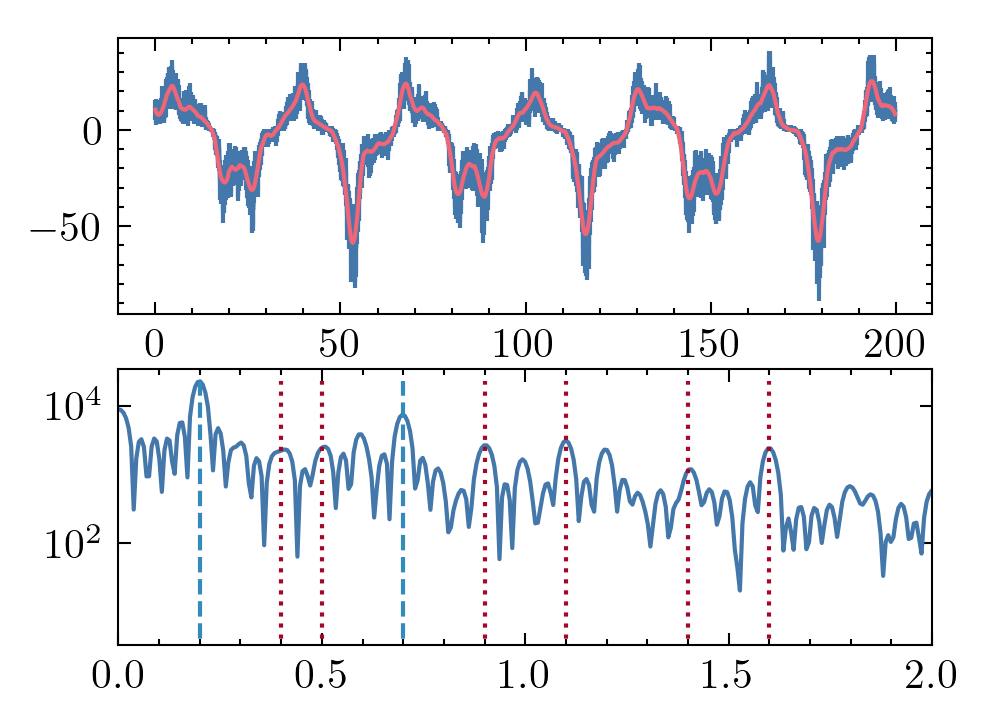

In [45]:
f1 = 20e7/1e9
f2 = 70e7/1e9

N           = 7
window      = 50
polyorder   = 3
signal      = dic_freq[N]['Current']
signal_sav  = savgol_filter(signal, window_length=window, polyorder=polyorder)
signal_sav  = signal_sav*bm
signal_sav  = signal.copy()
xf, yf      = fft(signal, 1e-10)

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=300)
    ax  = fig.add_subplot(2,1,1)
    ax.errorbar(time_vals, signal, dic_freq[N]['Error'])
    ax.plot(time_vals, signal_sav, zorder=10)
    
    ax  = fig.add_subplot(2,1,2)
    ax.plot(xf/1e9, yf)
    ax.vlines(f1, 0, np.max(yf), colors='#348ABD', linestyles='dashed')
    ax.vlines(f2, 0, np.max(yf), colors='#348ABD', linestyles='dashed')
    ax.vlines(f2-f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(f2+f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(2*f2, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(2*f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(f2+2*f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(f1+2*f2, 0, np.max(yf), colors='#A60628', linestyles='dotted')

    plt.yscale('log')
    plt.xlim(0,2)
    # plt.ylim(1000,100000)

/home/jonas/.local/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,47 m=1999 fp=505472.450201 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


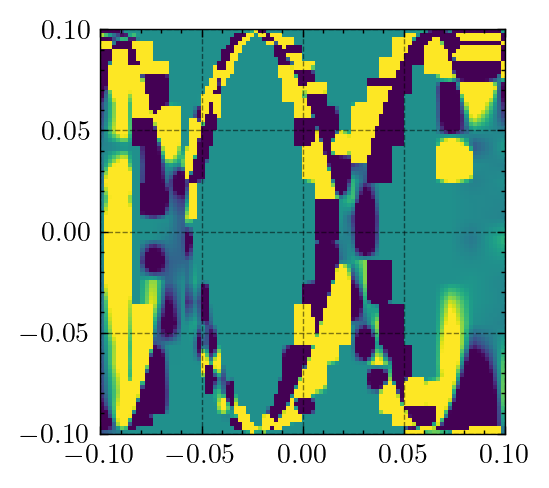

In [39]:
N   = 7
f   = interp2d(dic_freq[N]['E0'], dic_freq[N]['E1'], dic_freq[N]['Current'], kind='linear')
x   = np.linspace(-0.1,0.1,100)
y   = np.linspace(-0.1,0.1,100)
Z   = f(x,y)

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax.imshow(Z, extent=[-0.1,0.1,-0.1,0.1], origin='lower', vmin=-25,vmax=25)
    # ax.scatter(dic_freq[N]['E0'], dic_freq[N]['E1'], dic_freq[N]['Current'], s=1)
    # ax.errorbar(dic_freq[N]['E0'], dic_freq[N]['Current'], dic_freq[N]['Error'], marker='', markevery=2, lw=0.5)
    # ax.set_ylabel('$I$ [pA]')
    # ax.set_xlabel('$t$ [ns]')

----

In [66]:
# Combine output currents
# average_outputs(f"R_dis/data/R_200_d/r1", 10, 10)
# average_outputs(f"R_dis/data/R_200_d/r2", 10, 10)
# average_outputs(f"R_dis/data/R_200_d/r3", 10, 10)
# average_outputs(f"R_spatl/data/R_200", 10, 10)
nanonets_utils.store_average_time_results(f"uniform/data", 7, 7, 1, 3, 50, 10)

# Combine states
# average_states(f"R_dis/data/R_200_d/r1", 10, 10)
# average_states(f"R_dis/data/R_200_d/r2", 10, 10)
# average_states(f"R_dis/data/R_200_d/r3", 10, 10)
# average_states(f"R_spatl/data/R_200", 10, 10)
nanonets_utils.store_average_time_states(f"uniform/data", 7, 7, 1, 3, 50, 10)

In [67]:
freq                = "f3/"
results             = pd.DataFrame()
results["t"]        = np.loadtxt("uniform/time.csv")[1:]*10**9
results['U1']       = pd.read_csv(f"uniform/data/Nx=7_Ny=7_Nz=1_Ne=3.csv")['E0']
results['U2']       = pd.read_csv(f"uniform/data/Nx=7_Ny=7_Nz=1_Ne=3.csv")['E1']
results['I']        = pd.read_csv(f"uniform/data/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
results['uI']       = pd.read_csv(f"uniform/data/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
# results["spatl_I"]  = pd.read_csv(f"R_spatl/data/R_200/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
# results["spatl_uI"] = pd.read_csv(f"R_spatl/data/R_200/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
# results["r1_I"]     = pd.read_csv(f"R_dis/data/R_200_d/r1/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
# results["r1_uI"]    = pd.read_csv(f"R_dis/data/R_200_d/r1/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
# results["r2_I"]     = pd.read_csv(f"R_dis/data/R_200_d/r2/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
# results["r2_uI"]    = pd.read_csv(f"R_dis/data/R_200_d/r2/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
# results["r3_I"]     = pd.read_csv(f"R_dis/data/R_200_d/r3/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
# results["r3_uI"]    = pd.read_csv(f"R_dis/data/R_200_d/r3/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
# results['m']    = results.rolling(25)['I'].mean()
results         = results.iloc[250:,:].reset_index(drop=True)
results

,t,U1,U2,I,uI
0,25.1,0.028366,0.021944,-100.0,44.497191
1,25.2,0.030278,0.028714,-300.0,76.288924
2,25.3,0.032178,0.035343,-120.0,48.694969
3,25.4,0.034065,0.041800,-120.0,48.694969
4,25.5,0.035939,0.048051,-380.0,85.505555
...,...,...,...,...,...
1744,199.5,-0.057294,0.021908,80.0,39.839679
1745,199.6,-0.058922,0.015030,60.0,34.536937
1746,199.7,-0.060526,0.008078,40.0,28.227646
1747,199.8,-0.062106,0.001087,140.0,52.543315


In [68]:
def fft(signal, step_size, factor=5):

    n_0         = int(len(signal)/2)
    signal_fft  = np.fft.fft(signal, factor*len(signal))
    freq        = np.fft.fftfreq(factor*len(signal)) / step_size * 2 * np.pi

    return freq[:n_0], np.abs(signal_fft[:n_0])

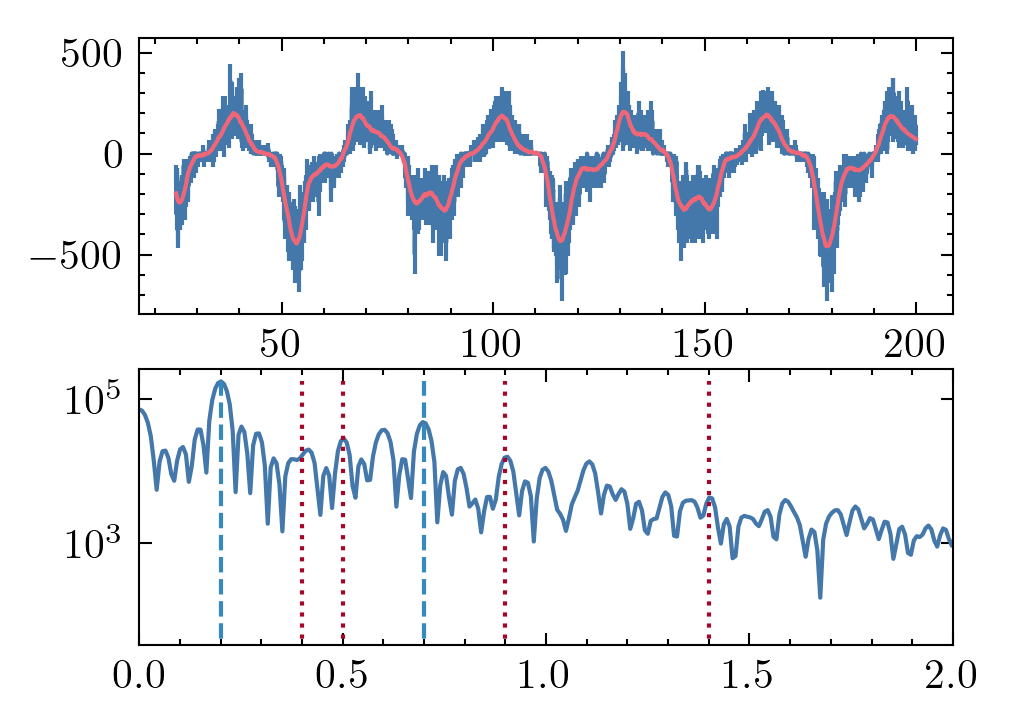

In [70]:
f1 = 20e7/1e9
f2 = 70e7/1e9

window      = 50
polyorder   = 3
signal      = results['I']
signal_sav  = savgol_filter(signal, window_length=window, polyorder=polyorder)
# signal_sav  = signal_sav*bm
# signal_sav  = signal.copy()
xf, yf      = fft(signal_sav, 1e-10)

with plt.style.context(["science","bright"]):
    fig = plt.figure(dpi=300)
    ax  = fig.add_subplot(2,1,1)
    ax.errorbar(results['t'], signal, results['uI'])
    ax.plot(results['t'], signal_sav, zorder=10)
    ax  = fig.add_subplot(2,1,2)
    ax.plot(xf/1e9, yf)
    # ax.stem(xf/1e9, yf)
    ax.vlines(f1, 0, np.max(yf), colors='#348ABD', linestyles='dashed')
    ax.vlines(f2, 0, np.max(yf), colors='#348ABD', linestyles='dashed')
    ax.vlines(f2-f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(f2+f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(2*f2, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    ax.vlines(2*f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    # ax.vlines(f2+2*f1, 0, np.max(yf), colors='#A60628', linestyles='dotted')
    # ax.vlines(f1+2*f2, 0, np.max(yf), colors='#A60628', linestyles='dotted')

    plt.yscale('log')
    plt.xlim(0,2)
    # plt.ylim(1000,100000)

(25.0, 30.0)

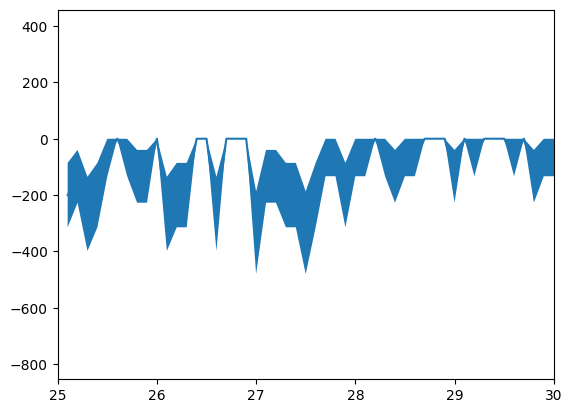

In [203]:
# plt.plot(results['t'], results['U1'])
# plt.plot(results['t'], results['U2'])
plt.plot(results['t'], results['I'])
plt.fill_between(results['t'], results['I']-results['uI'], results['I']+results['uI'])
plt.xlim(25,30)
# plt.plot(results['t'], results['m'], zorder=10)

In [66]:
def return_fft(arr : np.array, step_size : float):

    arr_norm    = (arr-np.min(arr))/(np.max(arr)-np.min(arr))

    yf          = np.fft.rfft(arr_norm)
    xf          = np.fft.rfftfreq(len(arr_norm), step_size)

    return xf, np.abs(yf) #2.0*np.abs(yf[:len(arr_norm)//2])

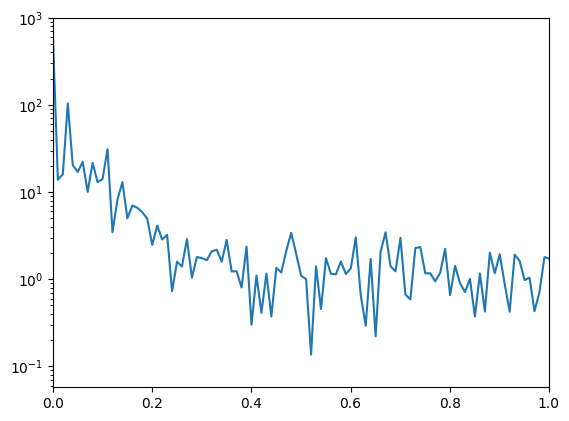

In [70]:
x1, y1 = return_fft(results['I'], 1e-10)

# plt.stem(x1/10**9, y1, markerfmt=" ", linefmt='#348ABD')
plt.plot(x1/10**9, y1)
plt.xlim(0,1)
# plt.ylim(1,100)
plt.yscale("log")

KeyError: 'r1_I'

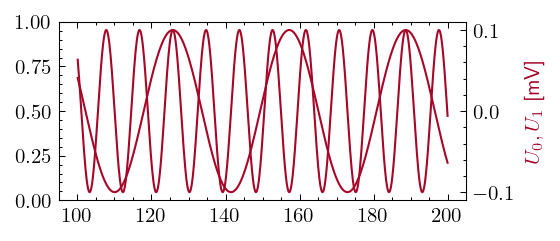

In [69]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=150)
    fig.set_figheight(fig.get_figheight()*2)

    ax  = fig.add_subplot(3,1,1)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U1'], c='#A60628')
    ax2.plot(results['t'], results['U2'], c='#A60628')
    ax2.set_ylabel("$U_0,U_1$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['r1_I']/1000, results['r1_uI']/1000, label='$Simulation 1$')
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.set_ylim(-3,3)

    ax  = fig.add_subplot(3,1,2)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U1'], c='#A60628')
    ax2.plot(results['t'], results['U2'], c='#A60628')
    ax2.set_ylabel("$U_0,U_1$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['r2_I']/1000, results['r2_uI']/1000, label='$Simulation 2$')
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.set_ylim(-3,3)

    ax  = fig.add_subplot(3,1,3)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U1'], c='#A60628')
    ax2.plot(results['t'], results['U2'], c='#A60628')
    ax2.set_ylabel("$U_0,U_1$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['r3_I']/1000, results['r3_uI']/1000, label='$Simulation 3$')
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylim(-3,3)
    # ax.errorbar(results['t'], results['r1_I']/1000, results['R_200_uI']/1000)
    # ax.errorbar(results['t'], results['R_400_I'], results['R_400_uI'])
    # fig.savefig('plots/i_o_comp.svg', bbox_inches='tight', transparent=True)
    # fig.savefig('plots/i_o_comp.pdf', bbox_inches='tight', transparent=False)

In [5]:
results['U']        = pd.read_csv(f"R_spatl/data/R_200/Nx=7_Ny=7_Nz=1_Ne=3.csv")['E0']
results["spatl_I"]  = pd.read_csv(f"R_spatl/data/R_200/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
results["spatl_uI"] = pd.read_csv(f"R_spatl/data/R_200/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
results["r1_I"]     = pd.read_csv(f"R_dis/data/R_200/r1/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
results["r1_uI"]    = pd.read_csv(f"R_dis/data/R_200/r1/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
results["r2_I"]     = pd.read_csv(f"R_dis/data/R_200/r2/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
results["r2_uI"]    = pd.read_csv(f"R_dis/data/R_200/r2/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']
results["r3_I"]     = pd.read_csv(f"R_dis/data/R_200/r3/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Current']
results["r3_uI"]    = pd.read_csv(f"R_dis/data/R_200/r3/Nx=7_Ny=7_Nz=1_Ne=3.csv")['Error']

In [30]:
dic = {
    "spatl"     : pd.read_csv(f"R_spatl/data/R_200/mean_state_Nx=7_Ny=7_Nz=1_Ne=3.csv"),
    "r1"        : pd.read_csv(f"R_dis/data/R_200_d/r1/mean_state_Nx=7_Ny=7_Nz=1_Ne=3.csv"),
    "r2"        : pd.read_csv(f"R_dis/data/R_200_d/r2/mean_state_Nx=7_Ny=7_Nz=1_Ne=3.csv"),
    "r3"        : pd.read_csv(f"R_dis/data/R_200_d/r3/mean_state_Nx=7_Ny=7_Nz=1_Ne=3.csv")
    # "R_400"   : pd.read_csv(f"1I_1O_R_corr/data/{freq}R_400/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")
}

for key, df in dic.items():
    dic[key] = df.iloc[1000:,:].reset_index(drop=True)

In [31]:
def scale_landscape(arr):
    return np.round((arr - np.min(arr,axis=0))/(np.max(arr,axis=0)-np.min(arr,axis=0)),2)

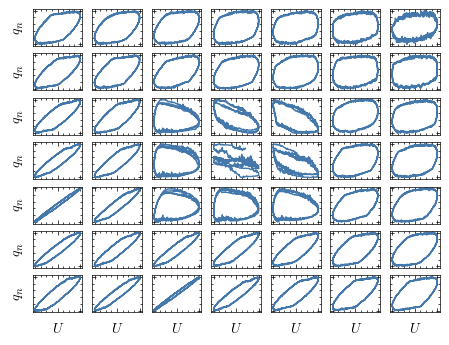

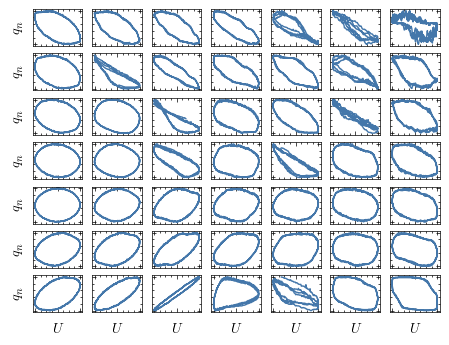

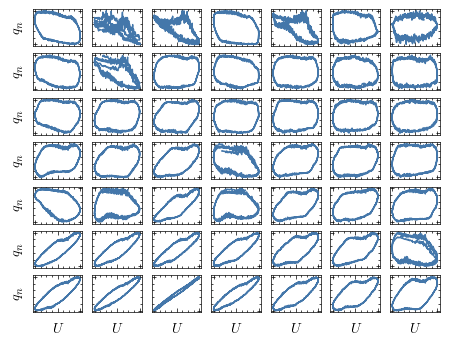

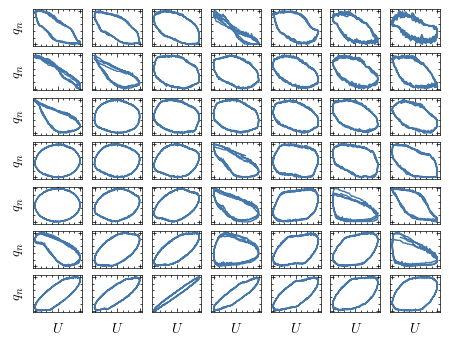

In [32]:
with plt.style.context(["science","bright"]):

    for key in ["spatl","r1","r2","r3"]:

        fig, axs = plt.subplots(ncols=7, nrows=7)

        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["U1"]*1000, scale_landscape(dic[key][f"{i}"]).values)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xticklabels("")
                    axs[row,col].set_xlabel("$U$")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_yticklabels("")
                    axs[row,col].set_ylabel("$q_n$")

                i += 1

        fig.savefig(f'plots/state_vs_U_{key}.svg', bbox_inches='tight', transparent=True)
        fig.savefig(f'plots/state_vs_U_{key}.pdf', bbox_inches='tight', transparent=False)

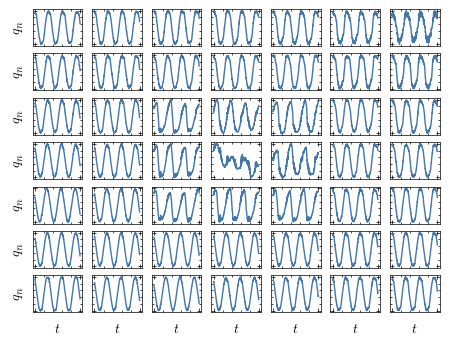

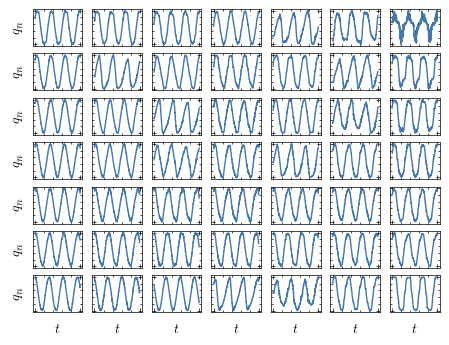

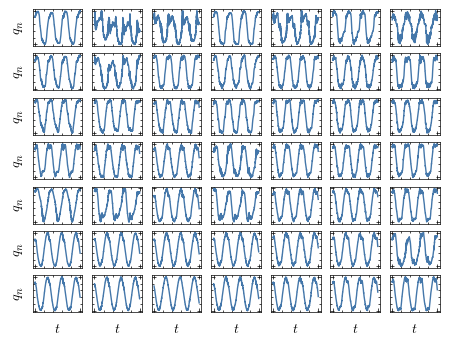

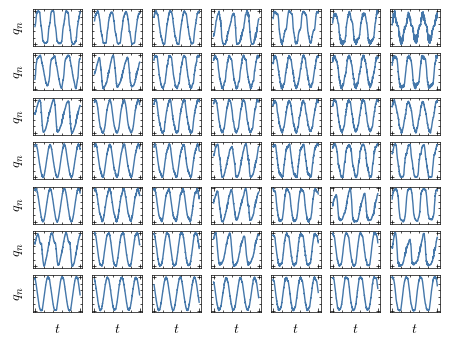

In [33]:
with plt.style.context(["science","bright"]):

    for key in ["spatl","r1","r2","r3"]:

        fig, axs = plt.subplots(ncols=7, nrows=7)

        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["t"], scale_landscape(dic[key][f"{i}"]).values)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xticklabels("")
                    axs[row,col].set_xlabel("$t$")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_yticklabels("")
                    axs[row,col].set_ylabel("$q_n$")

                i += 1

        fig.savefig(f'plots/state_vs_time_{key}.svg', bbox_inches='tight', transparent=True)
        fig.savefig(f'plots/state_vs_time_{key}.pdf', bbox_inches='tight', transparent=False)

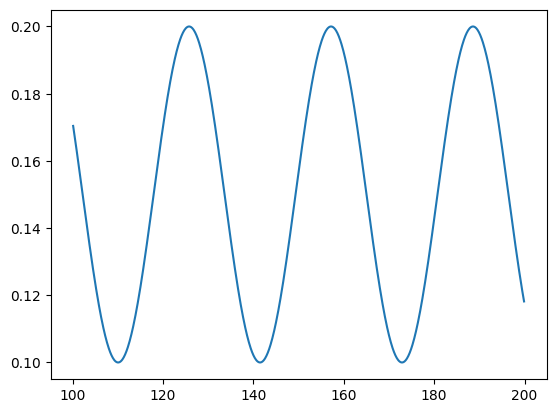

In [285]:
plt.plot(results["t"], results["U"])

In [33]:
from scipy.fft import fft, rfft, fftfreq, rfftfreq

In [34]:
def return_fft(arr : np.array, step_size : float):

    arr_norm    = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    sample_rate = 1/step_size

    xf      = rfftfreq(len(arr), 1. / sample_rate)
    yf      = np.abs(rfft(arr_norm))

    # xf          = np.fft.rfftfreq(len(arr), d=1./sample_rate)
    # yf          = 2*np.abs(np.fft.rfft(arr))/len(arr)

    return xf, yf

In [35]:
results

,t,U,spatl_I,spatl_uI,r1_I,r1_uI,r2_I,r2_uI,r3_I,r3_uI
0,100.1,0.081616,2100.0,407.308237,500.0,217.944947,500.0,217.944947,1900.0,392.300905
1,100.2,0.077949,2400.0,449.888875,700.0,255.147016,900.0,286.181760,1700.0,375.632799
2,100.3,0.074250,2000.0,400.000000,1000.0,300.000000,500.0,217.944947,1400.0,374.699880
3,100.4,0.070521,3000.0,479.583152,600.0,237.486842,1000.0,300.000000,1700.0,401.372645
4,100.5,0.066764,3400.0,494.368284,600.0,237.486842,500.0,217.944947,1400.0,346.987031
...,...,...,...,...,...,...,...,...,...,...
994,199.5,-0.114589,2000.0,400.000000,300.0,170.587221,500.0,217.944947,500.0,217.944947
995,199.6,-0.117844,1400.0,346.987031,300.0,170.587221,800.0,271.293199,1400.0,346.987031
996,199.7,-0.121052,1800.0,384.187454,200.0,140.000000,900.0,286.181760,600.0,237.486842
997,199.8,-0.124212,1500.0,357.071421,0.0,0.000000,700.0,255.147016,700.0,255.147016


In [36]:
arr1 = results["U"].values
arr2 = dic["r1"].values[:,24]
arr3 = results["spatl_I"].values

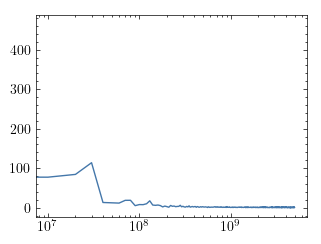

In [39]:
arr     = dic["spatl"].values[:,24]
xf, yf  = return_fft(arr, 1e-10)

with plt.style.context(["science","bright"]):
    
    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(xf, yf)
    ax.set_xscale("log")

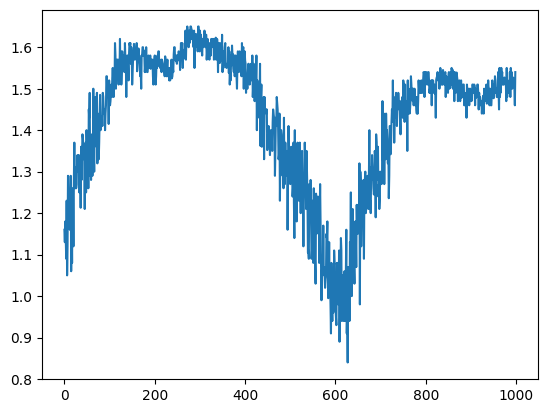

In [266]:
plt.plot(arr2)

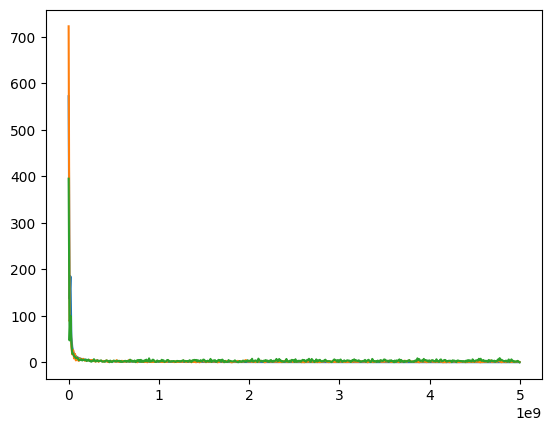

In [268]:
step_size   = 1e-10
x, y        = return_fft(arr1, step_size)
plt.plot(x, y)
x, y        = return_fft(arr2, step_size)
plt.plot(x, y)
x, y        = return_fft(arr3, step_size)
plt.plot(x, y)
plt.xlim(0,1e8)

In [41]:
def nonlinear_index(df : pd.DataFrame, main_frequency : float, sample_rate : float, time_scale=10**6, number_of_frequencies=10):

    N_values    = len(df)
    values      = []

    for col in df.columns:

        # Fourier Spectrum
        arr     = df.loc[:,col].values
        xf      = rfftfreq(N_values-1, 1 / sample_rate)/time_scale
        yf      = 2*np.abs(rfft(arr))/N_values
        df_f    = pd.DataFrame([xf, yf]).T
        df_f    = df_f[df_f[0] >= main_frequency/time_scale]
        df_f    = df_f.loc[df_f.loc[:,1].nlargest(number_of_frequencies).index].reset_index(drop=True)

        a       = df_f.iloc[1:,1].sum()
        b       = df_f.iloc[0,1]

        n_idx   = a/b
        values.append(n_idx)

    return values

In [21]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,2,0],[2,0,0],[6,6,0]]
}

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

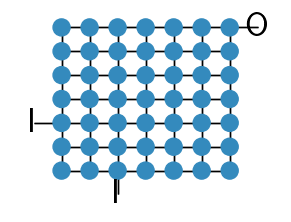

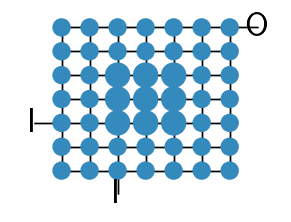

In [24]:
node_size = 150

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size, provide_electrode_labels=["I","I","O"], font_size=25)
fig.savefig('plots/network_plot.svg', bbox_inches='tight', transparent=True)
fig.savefig('plots/network_plot.pdf', bbox_inches='tight', transparent=False)

node_size = np.repeat(150, 52)

for i in [16,17,18,23,24,25,30,31,32]:
    node_size[i] = 300

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size, provide_electrode_labels=["I","I","O"], font_size=25)
fig.savefig('plots/network_plot_radius.svg', bbox_inches='tight', transparent=True)
fig.savefig('plots/network_plot_radius.pdf', bbox_inches='tight', transparent=False)